### [Probability calibrarion](https://scikit-learn.org/stable/modules/calibration.html)

__Calibration curves__ aka __reliability diagrams__ compare probabilistic predictions of a binary classifier. It plots the __frequency of the positive label__ vs the __predicted probability__ `predict_proba`. 

The tricky part is to get values for the y-axis. scikit-learn returns the average predicted probability in each bin. The y-axis is the fraction of positives given the predictions of that bin, i.e. the proportion of samples whose class is the positive class (in each bin).

The top calibration curve plot is created with __CalibrationDisplay.from_estimator__, which uses __calibration_curve__ to find the per-bin average predicted probabilities and fraction of positives. It uses a fitted classifier, which is used to calculate the predicted probabilities. The classifier thus must have a `predict_proba` method. 

For the few classifiers that do not have a predict_proba method, it is possible to use CalibratedClassifierCV to calibrate the classifier outputs to probabilities.

### [Example: Classifier Confidence Comparison](https://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html)

Well calibrated classifiers are __probabilistic__. `predict_proba` can be directly interpreted as a confidence level. 

For instance, a well calibrated (binary) classifier should classify samples so that samples with a `predict_proba` = 0.8 should have approx 80% actually belonging to the positive class. 

Below: compare the calibration of __Logistic regression__, __Gaussian Naive Bayes__, __Random Forest Classifier__ and __Linear SVM__.

In [5]:
# synthetic dataset, 100K samples, 20 features, 2 informative, 2 redundant, remaining 16 = useless (random numbers)

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=100_000, n_features=20, n_informative=2, n_redundant=2, random_state=42)

train_samples = 100  # Samples used for training the models
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=False,
    test_size=100_000 - train_samples)

In [6]:
import numpy as np
from sklearn.svm import LinearSVC

class NaivelyCalibratedLinearSVC(LinearSVC):
    """LinearSVC with `predict_proba` method that naively scales `decision_function` output."""

    def fit(self, X, y):
        super().fit(X, y)
        df           = self.decision_function(X)
        self.df_min_ = df.min()
        self.df_max_ = df.max()

    def predict_proba(self, X):
        """Min-max scale output of `decision_function` to [0,1]."""
        df              = self.decision_function(X)
        calibrated_df   = (df - self.df_min_) / (self.df_max_ - self.df_min_)
        proba_pos_class = np.clip(calibrated_df, 0, 1)
        proba_neg_class = 1 - proba_pos_class
        proba           = np.c_[proba_neg_class, proba_pos_class]
        return proba

In [7]:
from sklearn.calibration import CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Create classifiers
lr = LogisticRegression()
gnb = GaussianNB()
svc = NaivelyCalibratedLinearSVC(C=1.0, dual="auto")
rfc = RandomForestClassifier()

clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (svc, "SVC"),
    (rfc, "Random forest"),
]

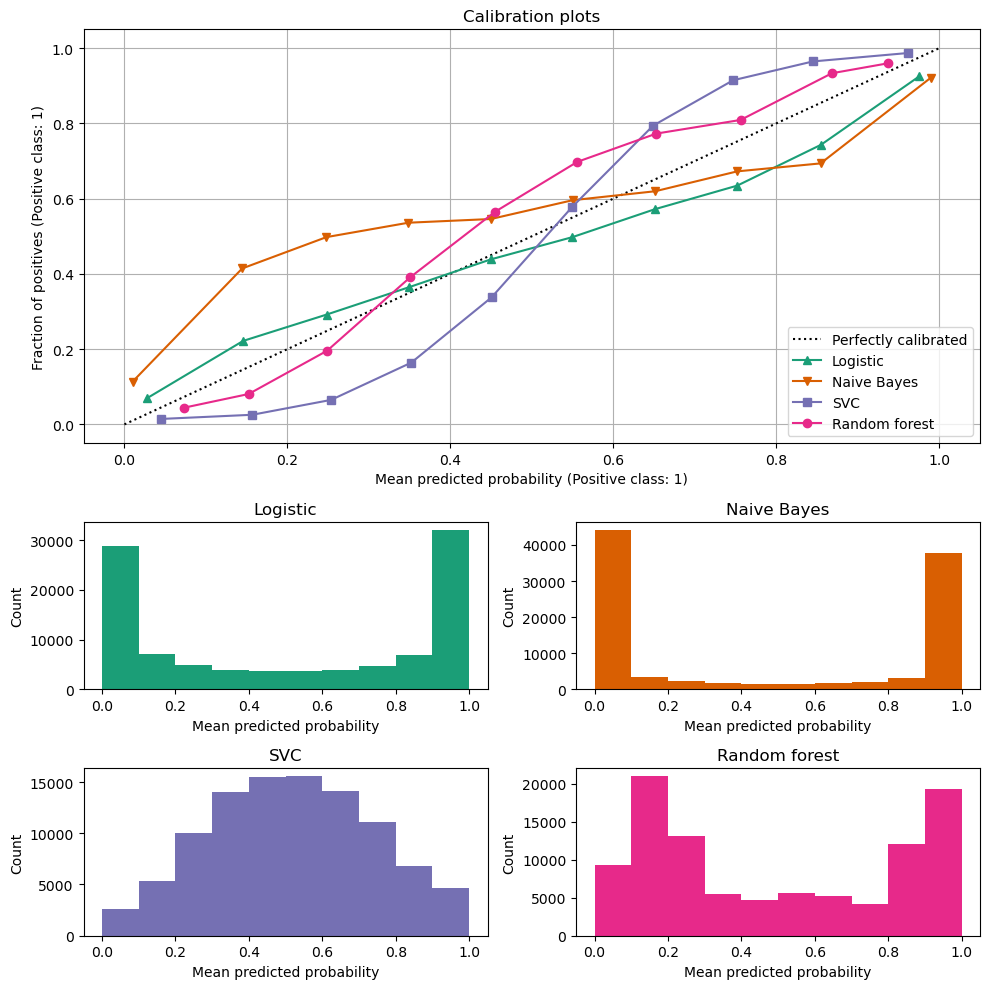

In [8]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v", "s", "o"]
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

__LogisticRegression__ does well - it directly optimizes log-loss. The other methods return biased probabilities, with different biases for each method:

__GaussianNB__ tends to push probabilities to 0 or 1 (see histogram). The naive Bayes equation only provides correct estimates when the assumption that features are conditionally independent is valid. Features tend to be positively correlated. This dataset contains 2 features generated as random linear combinations of the informative features. These __correlated features are effectively being ‘counted twice’__, resulting in pushing the predicted probabilities towards 0 and 1.

__RandomForestClassifier__ shows the opposite behavior: the __histograms show peaks at approx. 0.2 and 0.9 probability__. Methods such as bagging and random forests that average predictions from a set of models have difficulty making predictions near 0 and 1 - variance in the underlying models will bias predictions that should be near zero or one away from these values. If we add noise to the trees, this noise will cause some trees to predict values larger than 0 for this case, thus moving the average prediction of the bagged ensemble away from 0. The calibration curve shows a characteristic sigmoid shape, indicating that the classifier is under-confident and could return probabilities closer to 0 or 1.

__To show the performance of __LinearSVC__, we scale the output of the decision_function to [0, 1] by applying __min-max scaling__, since SVC does not output probabilities by default. LinearSVC shows an __even more sigmoid curve__ - typical for maximum-margin methods. They focus on difficult-to-classify samples that are close to the decision boundary (the support vectors).

### Calibrating a classifier

Calibrating a classifier consists of __fitting a regressor (aka 'calibrator')__ that __maps classifier outputs (from `decision_function` or `predict_proba`) to a calibrated probability in [0, 1]. The calibrator tries to predict the conditional event probability

Ideally, the dataset independent of the training data used to fit the classifier in the first place. This is because performance of the classifier on its training data would be better than for novel data. Using the classifier output of training data to fit the calibrator would thus result in a biased calibrator that maps to probabilities closer to 0 and 1 than it should.

### Usage

__CalibratedClassifierCV__ calibrates classifiers.

The data is split into k (train_set, test_set) couples. When `ensemble=True` (default), a clone of `base_estimator` is trained on the training subset for each split. Its predictions on the test subset are used to fit a calibrator (either a sigmoid or isotonic regressor). 

This results in an __ensemble of k (classifier, calibrator) couples__. Each calibrator maps the output of its corresponding classifier into [0, 1]. Each couple is in `calibrated_classifiers_` - each entry is a calibrated classifier with a `predict_proba` method. `predict_proba` for the main __CalibratedClassifierCV__ instance is the average of the k estimators in `calibrated_classifiers_`. The output of `predict` is the class that has the highest probability.

When `ensemble=False`, CV finds ‘unbiased’ predictions for all the data, via `cross_val_predict`. These unbiased predictions are then used to train the calibrator. `calibrated_classifiers_` contains only one (classifier, calibrator) couple where the classifier is the base_estimator trained on all the data. In this case the output of predict_proba for CalibratedClassifierCV is the predicted probabilities obtained from the single (classifier, calibrator) couple.

`ensemble=True` benefits from the __traditional ensembling effect__ (similar to Bagging meta-estimator). The resulting ensemble should both be well calibrated and slightly more accurate than with ensemble=False. `ensemble=False` __reduces the overall fit time__ by training only a single base classifier and calibrator pair, decreases the final model size and increases prediction speed.

A previously fitted classifier can be calibrated by setting `cv="prefit"`. In this case, the data is not split and all of it is used to fit the regressor. It is up to the user to make sure that the data used for fitting the classifier is disjoint from the data used for fitting the regressor.

CalibratedClassifierCV uses __"sigmoid"__ and __"isotonic"__ regression techniques. They are set in __method__.


__method="sigmoid"__ assumes the calibration curve can be corrected by applying a sigmoid function to the raw predictions. Additionally, the logistic model works best if the calibration error is symmetrical (the classifier output for each binary class is normally distributed with the same variance). __This can be a problem for highly imbalanced classification problems__, where outputs do not have equal variance.

This method is most effective for __small sample sizes__ or when the __un-calibrated model is under-confident__ and has similar calibration errors for both high and low outputs.

__method="isotonic"__ fits a non-parametric isotonic regressor then returns a step-wise non-decreasing function. This method is more general when compared to ‘sigmoid’ as __the only restriction is that the mapping function is monotonically increasing__. It is thus more powerful as it can correct any monotonic distortion of the un-calibrated model. It will perform better than ‘sigmoid’ when there is enough data (greater than ~ 1000 samples) to avoid overfitting

### [example: 3-class calibration](https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_multiclass.html#sphx-glr-auto-examples-calibration-plot-calibration-multiclass-py)

In [9]:
# dataset: 2000 samples, 2 features and 3 target classes.
# train: 600 samples (for training the classifier)
# valid: 400 samples (for calibrating predicted probabilities)
# test: 1000 samples
# also create X_train_valid and y_train_valid (both train and valid subsets). 
# This is used when we only want to train the classifier but not calibrate the predicted probabilities.

import numpy as np
from sklearn.datasets import make_blobs
np.random.seed(0)

X, y = make_blobs(
    n_samples=2000, n_features=2, centers=3, random_state=42, cluster_std=5.0)

X_train, y_train             = X[:600],     y[:600]
X_valid, y_valid             = X[600:1000], y[600:1000]
X_train_valid, y_train_valid = X[:1000],    y[:1000]
X_test, y_test               = X[1000:],    y[1000:]

In [10]:
# train a random forest classifier with 25 estimators

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=25)
clf.fit(X_train_valid, y_train_valid)

RandomForestClassifier(n_estimators=25)

In [11]:
# To train the calibrated classifier, start with the same RFC but train it using only the train data subset (600 samples) 
# then calibrate, with method='sigmoid', using the valid data subset (400 samples) in a 2-stage process.

from sklearn.calibration import CalibratedClassifierCV

clf     = RandomForestClassifier(n_estimators=25)
cal_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")

clf.fit(    X_train, y_train)
cal_clf.fit(X_valid, y_valid)

CalibratedClassifierCV(cv='prefit',
                       estimator=RandomForestClassifier(n_estimators=25))

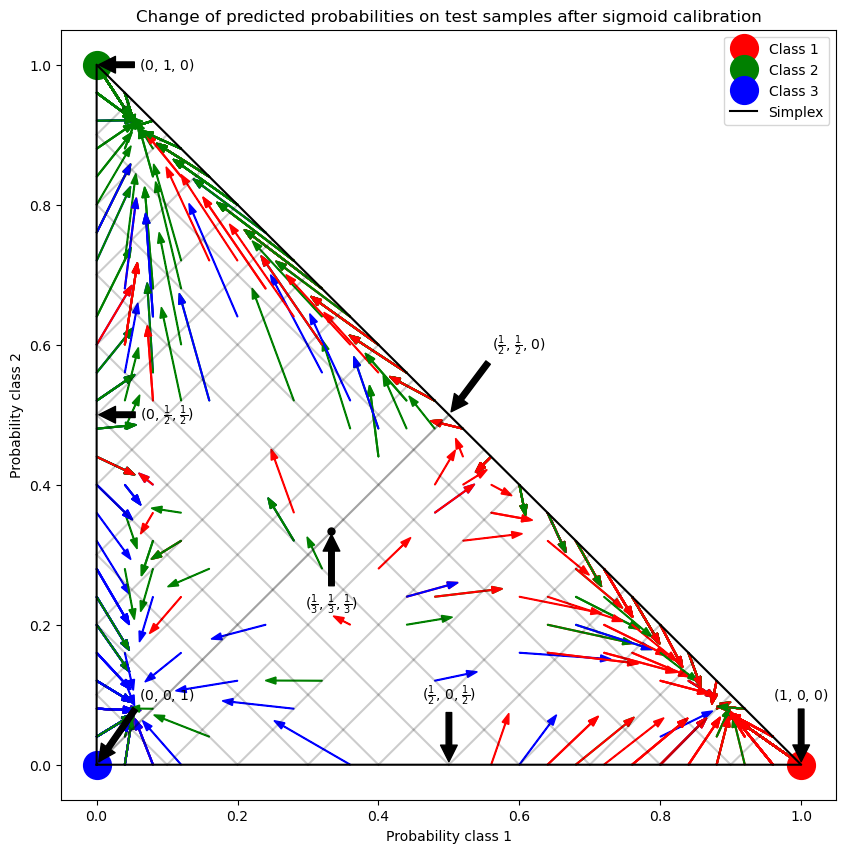

In [12]:
# compare probabilities
# plot a 2-simplex with arrows showing the change in predicted probabilities of the test samples.

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))

colors        = ["r", "g", "b"]
clf_probs     = clf.predict_proba(X_test)
cal_clf_probs = cal_clf.predict_proba(X_test)

# Plot arrows
for i in range(clf_probs.shape[0]):
    plt.arrow(
        clf_probs[i, 0],
        clf_probs[i, 1],
        cal_clf_probs[i, 0] - clf_probs[i, 0],
        cal_clf_probs[i, 1] - clf_probs[i, 1],
        color=colors[y_test[i]],
        head_width=1e-2,
    )

# Plot perfect predictions, at each vertex
plt.plot([1.0], [0.0], "ro", ms=20, label="Class 1")
plt.plot([0.0], [1.0], "go", ms=20, label="Class 2")
plt.plot([0.0], [0.0], "bo", ms=20, label="Class 3")

# Plot boundaries of unit simplex
plt.plot([0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], "k", label="Simplex")

# Annotate points 6 points around the simplex, and mid point inside simplex
plt.annotate(
    r"($\frac{1}{3}$, $\frac{1}{3}$, $\frac{1}{3}$)",
    xy=(1.0 / 3, 1.0 / 3),
    xytext=(1.0 / 3, 0.23),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.plot([1.0 / 3], [1.0 / 3], "ko", ms=5)
plt.annotate(
    r"($\frac{1}{2}$, $0$, $\frac{1}{2}$)",
    xy=(0.5, 0.0),
    xytext=(0.5, 0.1),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($0$, $\frac{1}{2}$, $\frac{1}{2}$)",
    xy=(0.0, 0.5),
    xytext=(0.1, 0.5),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($\frac{1}{2}$, $\frac{1}{2}$, $0$)",
    xy=(0.5, 0.5),
    xytext=(0.6, 0.6),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($0$, $0$, $1$)",
    xy=(0, 0),
    xytext=(0.1, 0.1),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($1$, $0$, $0$)",
    xy=(1, 0),
    xytext=(1, 0.1),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($0$, $1$, $0$)",
    xy=(0, 1),
    xytext=(0.1, 1),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
# Add grid
plt.grid(False)
for x in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.plot([0, x], [x, 0], "k", alpha=0.2)
    plt.plot([0, 0 + (1 - x) / 2], [x, x + (1 - x) / 2], "k", alpha=0.2)
    plt.plot([x, x + (1 - x) / 2], [0, 0 + (1 - x) / 2], "k", alpha=0.2)

plt.title("Change of predicted probabilities on test samples after sigmoid calibration")
plt.xlabel("Probability class 1")
plt.ylabel("Probability class 2")
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
_ = plt.legend(loc="best")

Each vertex of the triangle represents a perfectly predicted class (e.g., 1, 0, 0). 

The mid point indicates the three classes with equal probability (i.e., 1/3, 1/3, 1/3). Each arrow starts at the uncalibrated probabilities and end with the arrow head at the calibrated probability. The color of the arrow represents the true class of that test sample.

The uncalibrated classifier is __overly confident and incurs a large log loss__. The calibrated classifier incurs a __lower log loss due to two factors__. 

__First__, note the arrows generally point away from the edges of the simplex - where the probability of one class is 0. __Second__, a large proportion of the arrows point towards the true class, e.g., green arrows (samples where the true class is ‘green’) generally point towards the green vertex. This results in fewer over-confident, 0 predicted probabilities and at the same time an increase in the predicted probabilities of the correct class.

We can verify this by __comparing the log loss__ on the predictions of the 1000 test samples.

In [13]:
from sklearn.metrics import log_loss
score     = log_loss(y_test, clf_probs)
cal_score = log_loss(y_test, cal_clf_probs)

print("Log-loss of")
print(f" * uncalibrated classifier: {score:.3f}")
print(f" * calibrated classifier: {cal_score:.3f}")

Log-loss of
 * uncalibrated classifier: 1.327
 * calibrated classifier: 0.549


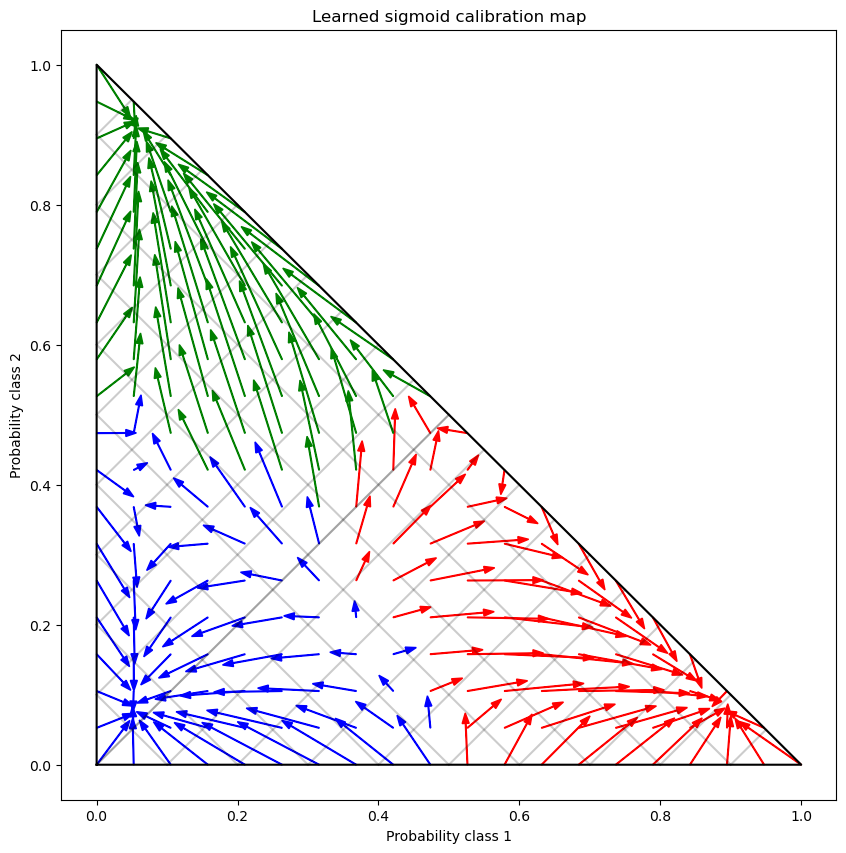

In [14]:
# Generate grid of possible uncalibrated probabilities over the 2-simplex, 
# find the corresponding calibrated probabilities and plot arrows for each. 
# The arrows are colored according the highest uncalibrated probability. 
# This illustrates the learned calibration map:

plt.figure(figsize=(10, 10))
p1d    = np.linspace(0, 1, 20) # Generate grid of probability values
p0, p1 = np.meshgrid(p1d, p1d)
p2     = 1 - p0 - p1
p      = np.c_[p0.ravel(), p1.ravel(), p2.ravel()]
p      = p[p[:, 2] >= 0]

# Use the three class-wise calibrators to compute calibrated probabilities
calibrated_classifier = cal_clf.calibrated_classifiers_[0]
prediction = np.vstack(
    [
        calibrator.predict(this_p)
        for calibrator, this_p in zip(calibrated_classifier.calibrators, p.T)
    ]
).T

# Re-normalize the calibrated predictions to make sure they stay inside the
# simplex. This same renormalization step is performed internally by the
# predict method of CalibratedClassifierCV on multiclass problems.
prediction /= prediction.sum(axis=1)[:, None]

# Plot changes in predicted probabilities induced by the calibrators
for i in range(prediction.shape[0]):
    plt.arrow(
        p[i, 0],
        p[i, 1],
        prediction[i, 0] - p[i, 0],
        prediction[i, 1] - p[i, 1],
        head_width=1e-2,
        color=colors[np.argmax(p[i])],
    )

# Plot the boundaries of the unit simplex
plt.plot([0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], "k", label="Simplex")

plt.grid(False)
for x in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.plot([0, x], [x, 0], "k", alpha=0.2)
    plt.plot([0, 0 + (1 - x) / 2], [x, x + (1 - x) / 2], "k", alpha=0.2)
    plt.plot([x, x + (1 - x) / 2], [0, 0 + (1 - x) / 2], "k", alpha=0.2)

plt.title("Learned sigmoid calibration map")
plt.xlabel("Probability class 1")
plt.ylabel("Probability class 2")
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

plt.show()

### [example: classifier probability calibration](https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration.html#sphx-glr-auto-examples-calibration-plot-calibration-py)

Classification often requires class labels AND probabilities. Not all classifiers provide well-calibrated probabilities, some being over-confident while others being under-confident. This example illustrates two different methods & evaluates the quality of the returned probabilities using Brier’s score (see https://en.wikipedia.org/wiki/Brier_score).

Compared: __Gaussian naive Bayes classifier without calibration__, with a __sigmoid__ calibration, and with a __non-parametric isotonic__ calibration. 

One can observe that only the non-parametric model is able to provide a probability calibration that returns probabilities close to the expected 0.5 for most of the samples belonging to the middle cluster with heterogeneous labels. This results in a significantly improved Brier score.

In [15]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

n_samples, n_bins = 50000, 3 # use 3 bins for calibration_curve as we have 3 clusters here

# Generate 3 blobs with 2 classes. second blob contains half positive samples and half negative samples. 
# Probability in this blob is therefore 0.5.

centers             = [(-5, -5), (0, 0), (5, 5)]
X, y                = make_blobs(n_samples=n_samples, centers=centers, shuffle=False, random_state=42)
y[: n_samples // 2] = 0
y[n_samples // 2 :] = 1
sample_weight       = np.random.RandomState(42).rand(y.shape[0])

# split train, test for calibration
X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(
    X, y, sample_weight, test_size=0.9, random_state=42)

In [16]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
from sklearn.naive_bayes import GaussianNB

clf          = GaussianNB()
clf_isotonic = CalibratedClassifierCV(clf, cv=2, method="isotonic")
clf_sigmoid  = CalibratedClassifierCV(clf, cv=2, method="sigmoid")

clf.fit(         X_train, y_train)  # GaussianNB itself does not support sample-weights
clf_isotonic.fit(X_train, y_train, sample_weight=sw_train)
clf_sigmoid.fit( X_train, y_train, sample_weight=sw_train)

prob_pos_clf      = clf.predict_proba(X_test)[:, 1]
prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]
prob_pos_sigmoid  = clf_sigmoid.predict_proba(X_test)[:, 1]

clf_score          = brier_score_loss(y_test, prob_pos_clf, sample_weight=sw_test)
clf_isotonic_score = brier_score_loss(y_test, prob_pos_isotonic, sample_weight=sw_test)
clf_sigmoid_score  = brier_score_loss(y_test, prob_pos_sigmoid, sample_weight=sw_test)

print("Brier score losses: (the smaller the better)")
print("No calibration: %1.3f" % clf_score)
print("With isotonic calibration: %1.3f" % clf_isotonic_score)
print("With sigmoid calibration: %1.3f" % clf_sigmoid_score)

Brier score losses: (the smaller the better)
No calibration: 0.104
With isotonic calibration: 0.084
With sigmoid calibration: 0.109


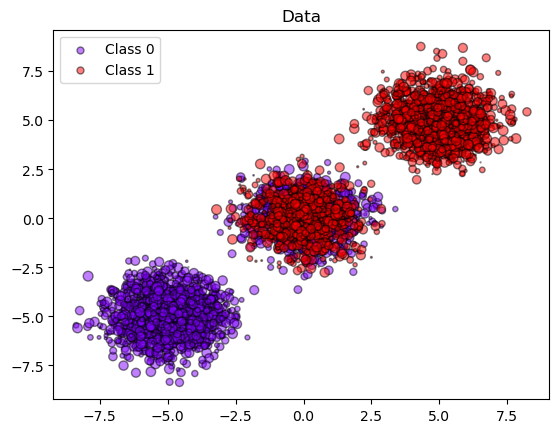

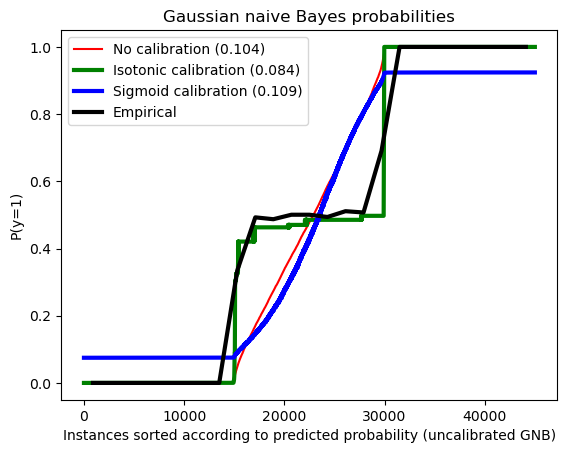

In [17]:
import matplotlib.pyplot as plt
from matplotlib import cm

plt.figure()
y_unique = np.unique(y)
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
for this_y, color in zip(y_unique, colors):
    this_X = X_train[y_train == this_y]
    this_sw = sw_train[y_train == this_y]
    plt.scatter(
        this_X[:, 0],
        this_X[:, 1],
        s=this_sw * 50,
        c=color[np.newaxis, :],
        alpha=0.5,
        edgecolor="k",
        label="Class %s" % this_y,
    )
plt.legend(loc="best")
plt.title("Data")

plt.figure()

order = np.lexsort((prob_pos_clf,))
plt.plot(prob_pos_clf[order], "r", label="No calibration (%1.3f)" % clf_score)
plt.plot(
    prob_pos_isotonic[order],
    "g",
    linewidth=3,
    label="Isotonic calibration (%1.3f)" % clf_isotonic_score,
)
plt.plot(
    prob_pos_sigmoid[order],
    "b",
    linewidth=3,
    label="Sigmoid calibration (%1.3f)" % clf_sigmoid_score,
)
plt.plot(
    np.linspace(0, y_test.size, 51)[1::2],
    y_test[order].reshape(25, -1).mean(1),
    "k",
    linewidth=3,
    label=r"Empirical",
)
plt.ylim([-0.05, 1.05])
plt.xlabel("Instances sorted according to predicted probability (uncalibrated GNB)")
plt.ylabel("P(y=1)")
plt.legend(loc="upper left")
plt.title("Gaussian naive Bayes probabilities")

plt.show()